# Sandbox notebook for data analysis and visualization

Author: Veikka Immonen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from PIL import Image

import scienceplots
plt.style.use('science')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

plt_original_resolution = plt.rcParams['figure.figsize']
plt_original_resolution

[3.5, 2.625]

## CytoSense

In [2]:
data_dir = Path('./data/CytoSense')
image_dir = data_dir / 'images'
fluorence_dir = data_dir / 'others'
annotations = pd.read_csv(data_dir / 'annotations.csv')
annotations

,X,class_name,has_image,has_fluorence
0,1,Aphanizomenon_flosaquae,True,False
1,2,Aphanizomenon_flosaquae,True,True
2,3,Aphanizomenon_flosaquae,True,True
3,4,Aphanizomenon_flosaquae,True,True
4,5,Aphanizomenon_flosaquae,True,True
...,...,...,...,...
14317,14353,Snowella-Woronichinia,True,False
14318,14354,Snowella-Woronichinia,True,False
14319,14355,Snowella-Woronichinia,True,False
14320,14356,Snowella-Woronichinia,True,False


### Statistics

Number of samples for each instance, how many of them are purely multimodal 
(images + all time series data)?

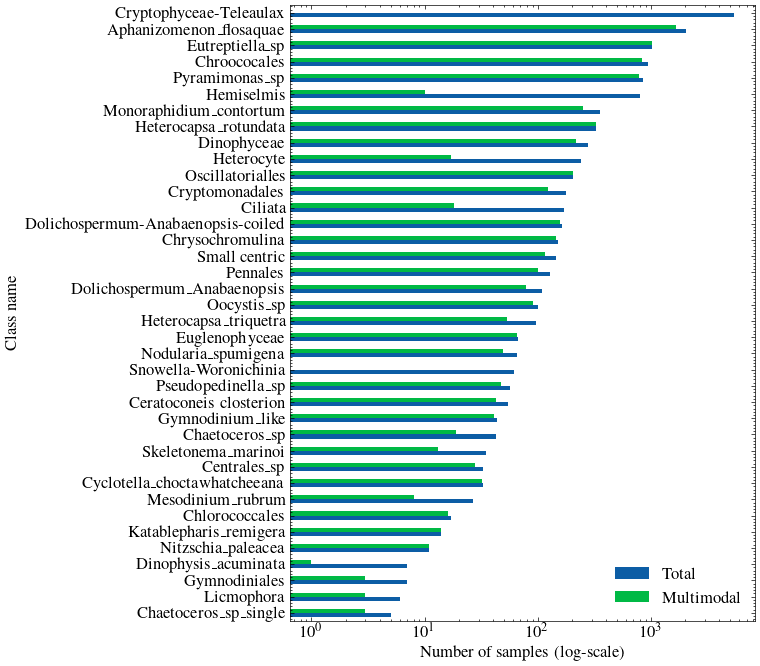

In [5]:
counter = Counter(annotations.class_name)

df = pd.DataFrame(
    index=annotations.class_name.unique(),
)

df['Total'] = counter.values()

for key in counter:
    counter[key] = 0

counter.update(annotations[annotations.has_fluorence == True].class_name)
df['Multimodal'] = counter.values()

df.sort_values('Total').plot(kind='barh', figsize=(6, 8))
plt.xlabel('Number of samples (log-scale)')
plt.ylabel('Class name')
plt.xscale('log')

# plt.savefig(f'sample_counts.pdf')
plt.show()

Rough selection would be to exclude classes with less than 10 multimodal samples.

### Visualization

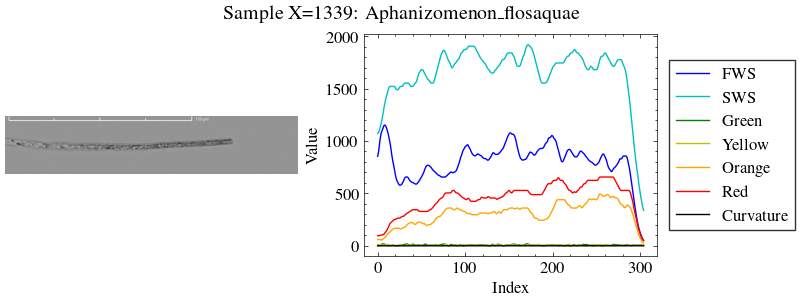

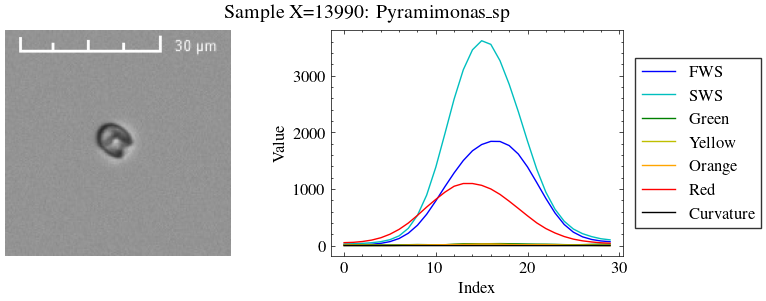

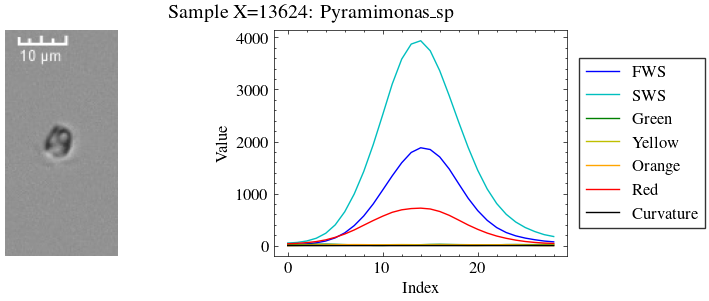

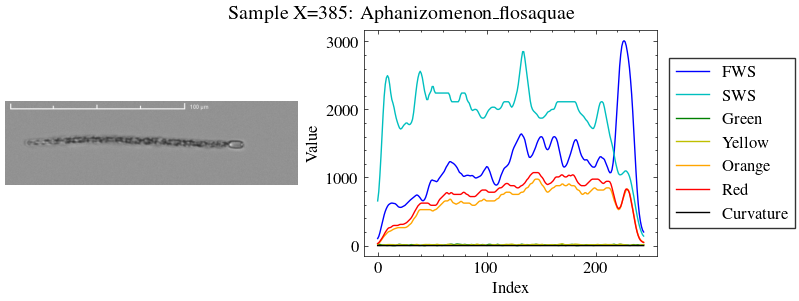

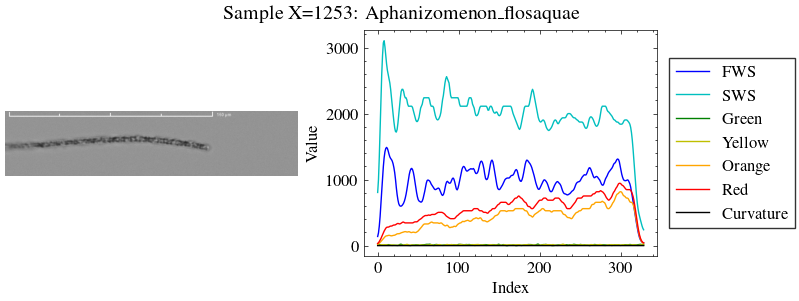

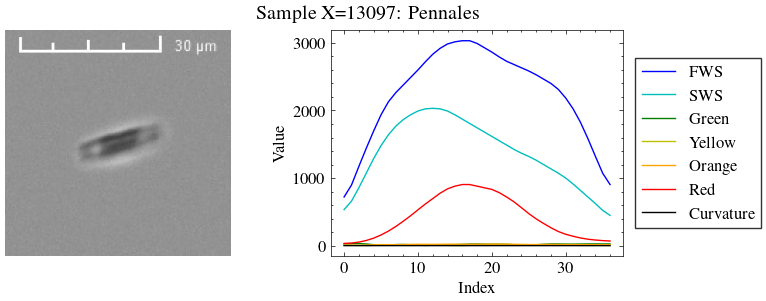

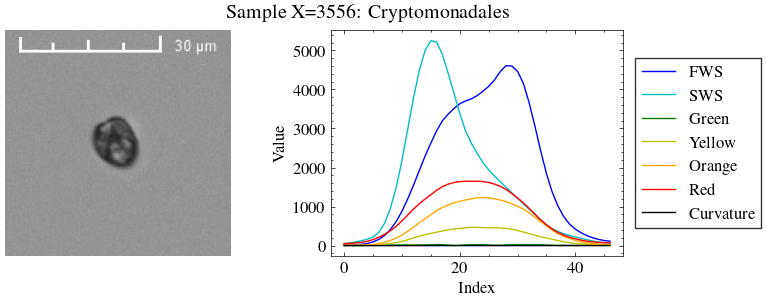

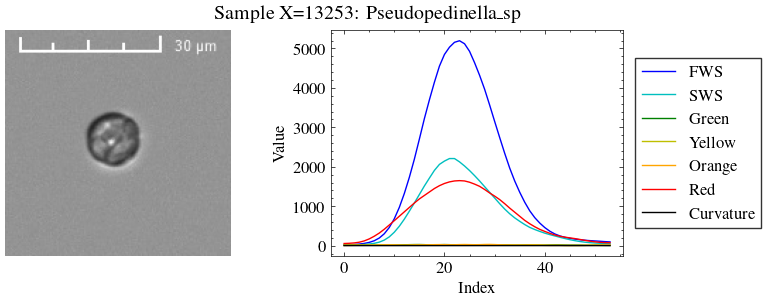

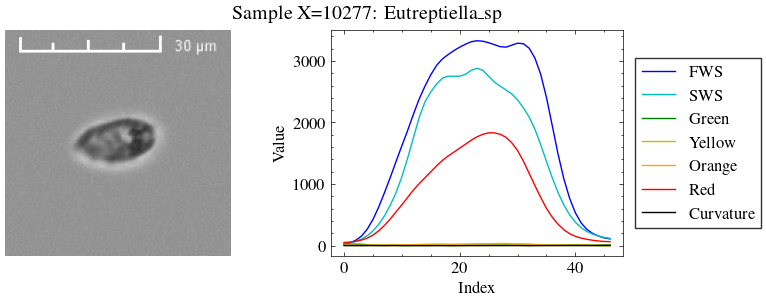

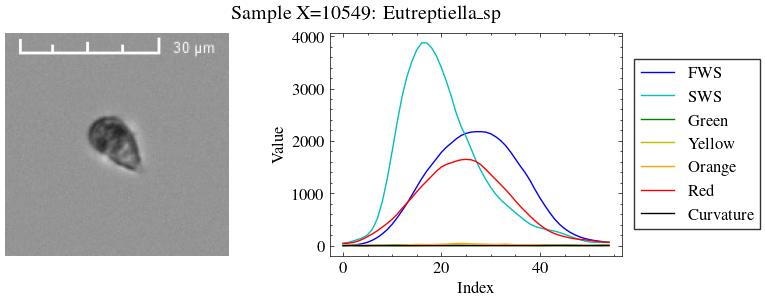

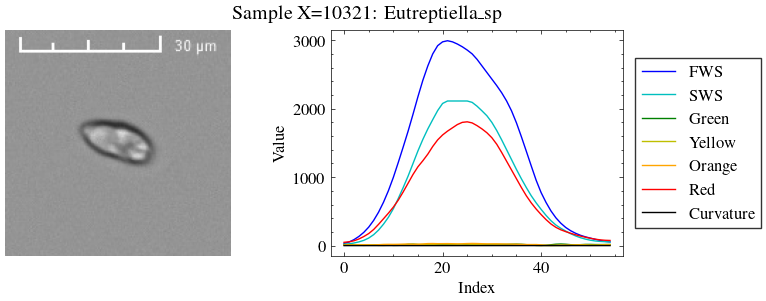

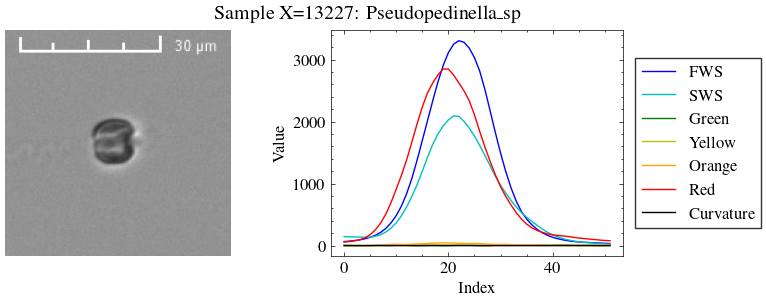

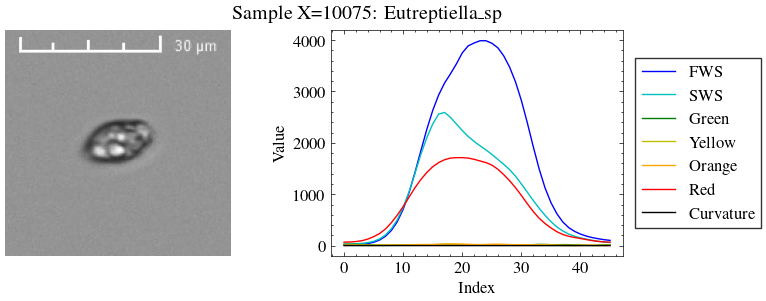

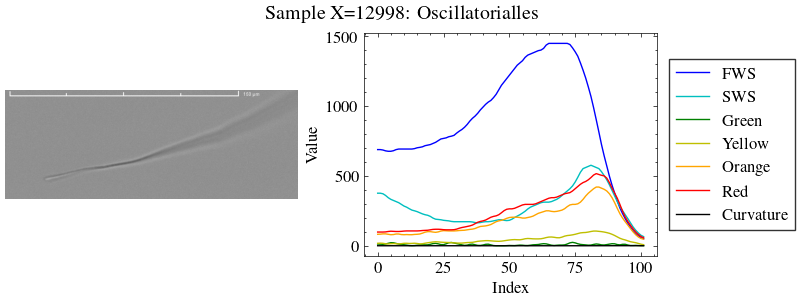

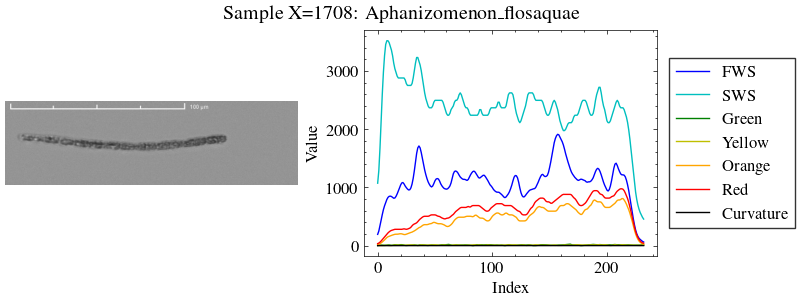

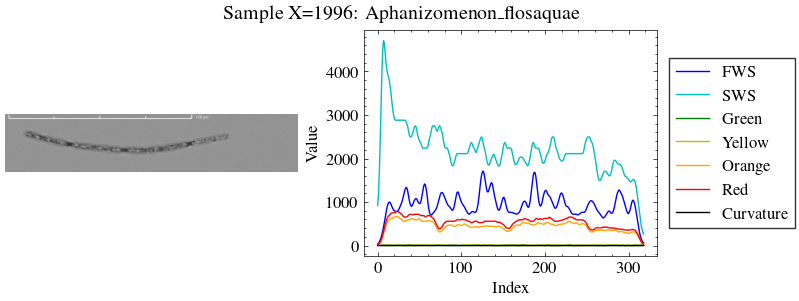

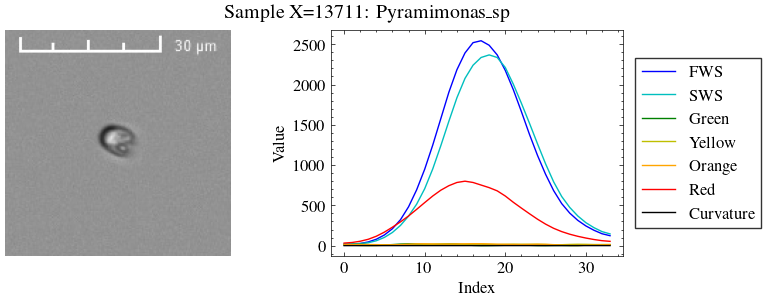

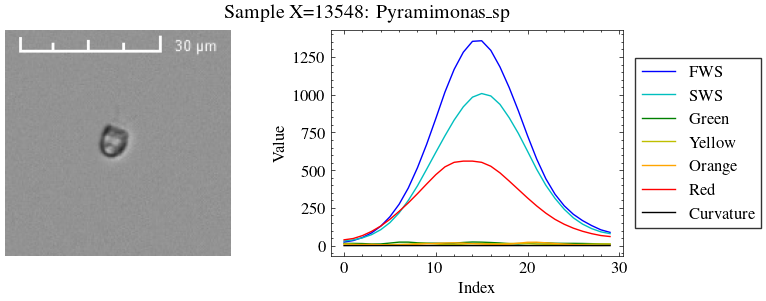

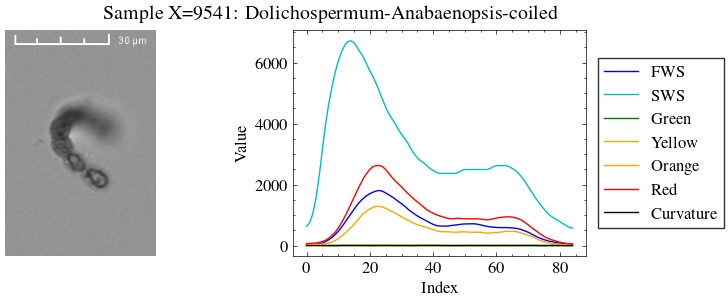

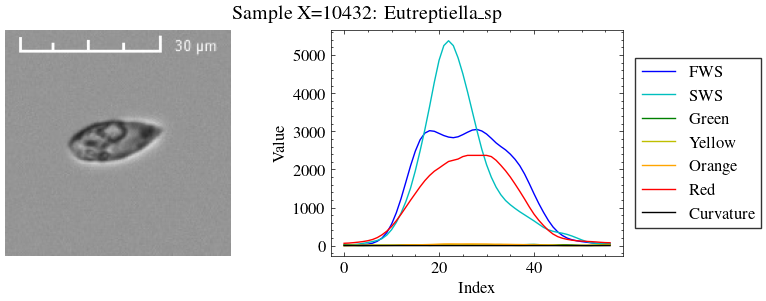

In [6]:
def visualize(sample):
    image = np.array(Image.open(image_dir / f"{sample.X}.jpg"))
    fluorence = pd.read_csv(fluorence_dir / f"{sample.X}.csv")

    styles = ['b', 'c', 'g', 'y', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = fluorence.plot(ax=ax2, style=dict(zip(fluorence.columns, styles)), figsize=(8, 3))
    ax2.legend(loc=7, frameon=True, edgecolor='k', fancybox=False, bbox_to_anchor=(1.5, 0.5))
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')

    plt.suptitle(f'Sample X={sample.X}: {sample.class_name}')
    # plt.savefig(f'{sample.X}.pdf')
    plt.show()

for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(20).iterrows():
    visualize(sample)

